<h1>Dataloading</h1>

In [1]:
import os
from glob import glob
import shutil
from tqdm import tqdm
import dicom2nifti
import numpy as np
import nibabel as nib
from monai.transforms import(
    Compose,
    AddChanneld,
    LoadImaged,
    Resized,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
)
from monai.data import DataLoader, Dataset, CacheDataset
from monai.utils import set_determinism


def prepare(in_dir, imaging_index, pixdim=(1.0, 1.0, 1.0), a_min=0, a_max=502, spatial_size=[128,128,128], trainloader_batchsize=1):
    print("Preparing...")
    set_determinism(seed=0)

    path_train_volumes = sorted(glob(os.path.join(in_dir, f"images_{imaging_index}", "*.nii.gz")))
    path_train_segmentation = sorted(glob(os.path.join(in_dir, "segmentation", "*.nii.gz")))

    '''DEBUG'''
    print(f"Length of path_train_volumes: {len(path_train_volumes)}")    
    print(f"Length of path_train_segmentation: {len(path_train_segmentation)}")    
    '''DEBUG'''

    train_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_train_volumes, path_train_segmentation)]

    train_transforms = Compose(
        [
            LoadImaged(keys=["vol", "seg"]),
            AddChanneld(keys=["vol", "seg"]),
            Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
            Orientationd(keys=["vol", "seg"], axcodes="RAS"),
            ScaleIntensityRanged(keys=["vol"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True), 
            CropForegroundd(keys=["vol", "seg"], source_key="vol"),
            Resized(keys=["vol", "seg"], spatial_size=spatial_size),   
            ToTensord(keys=["vol", "seg"]),

        ]
    )

    train_ds = CacheDataset(data=train_files, transform=train_transforms,cache_rate=1.0)
    train_loader = DataLoader(train_ds, batch_size=trainloader_batchsize, pin_memory=True)
    print("Preparing done.")

    return train_loader


In [2]:
training_directory="D:/MLDatasets/TCGA-GBM Datasets/Training"

'''CHANGE IMAGING INDEX FOR TYPE OF MRI'''
imaging_index=0 # Use FLAIR as main
data_f = prepare(in_dir=training_directory, imaging_index=imaging_index)

Preparing...
Length of path_train_volumes: 102
Length of path_train_segmentation: 102


Loading dataset: 100%|██████████| 102/102 [01:08<00:00,  1.48it/s]

Preparing done.


In [3]:
trainloader = data_f

Image shape is: torch.Size([1, 1, 128, 128, 128])
Label shape is: torch.Size([1, 1, 128, 128, 128])


C:\Users\steve\AppData\Local\Temp\ipykernel_17088\329993585.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(53, 54)):


  0%|          | 0/1 [00:00<?, ?it/s]

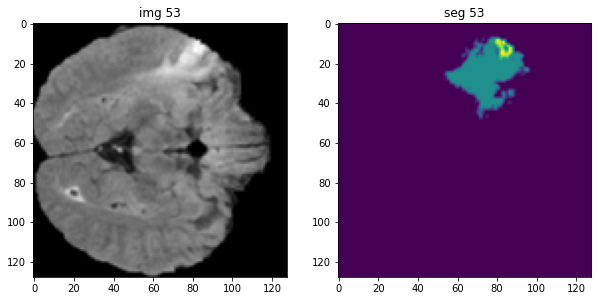

In [4]:
from monai.utils import first
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook
firstdata = first(trainloader)
print(f"Image shape is: {firstdata['vol'].shape}")
print(f"Label shape is: {firstdata['seg'].shape}")

for i in tqdm_notebook(range(53, 54)):
    plt.figure("Training NIFTI", (10, 5))
    plt.subplot(1, 2, 1)
    plt.title(f"img {i}")
    plt.imshow(firstdata['vol'][0, 0, :, :, i], cmap="gray")
    plt.subplot(1, 2, 2)
    plt.title(f"seg {i}")
    plt.imshow(firstdata['seg'][0, 0, :, :, i])
    plt.show()

<h1>Training</h1>

In [5]:
model_storage = "D:/MLDatasets/TCGA-GBM Datasets/Models"

<h3>UNET Definition</h3>

In [6]:
import os
import torch
import torch.nn as nn
import pytorch_lightning as pl
import torch.nn.functional as F
from monai.networks.nets import UNet
from monai.networks.layers import Norm 
from monai.losses import DiceLoss

from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split


class UNETTransfer(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = UNet(
            dimensions=3,
            in_channels=1,
            out_channels=2,
            channels=(16, 32, 64, 128, 256), 
            strides=(2, 2, 2, 2),
            num_res_units=2,
            norm=Norm.BATCH
        )
        self.loss = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)

    def training_step(self, batch, batch_idx):
        vol, seg = batch['vol'], batch['seg']
        out = self.model(vol)
        res_loss = self.loss(out, vol)
        self.log('train loss',  res_loss)
        return res_loss 
     
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), 1e-5, weight_decay=1e-5, amsgrad=True)

test_model = UNETTransfer()
print(test_model.model)

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(


<h3>SegResNetVAE Definition</h3>

In [31]:
import os
import torch
import torch.nn as nn
import pytorch_lightning as pl
import torch.nn.functional as F
from monai.networks.nets import SegResNet
from monai.networks.layers import Norm 
from monai.losses import DiceLoss

from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split


class SegResNetTransfer(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = SegResNet(
            spatial_dims=3,
            out_channels=2,
            dropout_prob=0.2
        )
        self.loss = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)

    def training_step(self, batch, batch_idx):
        vol, seg = batch['vol'], batch['seg']
        out = self.model(vol)
        res_loss = self.loss(out, vol)
        self.log('train loss',  res_loss)
        return res_loss 
     
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), 1e-5, weight_decay=1e-5, amsgrad=True)

test_model = SegResNetTransfer()
print(test_model.model)

SegResNet(
  (act_mod): ReLU(inplace=True)
  (convInit): Convolution(
    (conv): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
  )
  (down_layers): ModuleList(
    (0): Sequential(
      (0): Identity()
      (1): ResBlock(
        (norm1): GroupNorm(8, 8, eps=1e-05, affine=True)
        (norm2): GroupNorm(8, 8, eps=1e-05, affine=True)
        (act): ReLU(inplace=True)
        (conv1): Convolution(
          (conv): Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        )
        (conv2): Convolution(
          (conv): Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        )
      )
    )
    (1): Sequential(
      (0): Convolution(
        (conv): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      )
      (1): ResBlock(
        (norm1): GroupNorm(8, 16, eps=1e-05, affine=True)
        (norm2): GroupNorm(8, 16, eps=1e-05, affine=Tr

In [32]:
print((len(trainloader)))

print(len(next(iter(trainloader))))

102
8


In [33]:
torch.cuda.empty_cache()

In [34]:
model = SegResNetTransfer()

'''SET TRAINING EPOCHS'''
epochs = 10 

#last_checkpoint = './lightning_logs/version_9/checkpoints/epoch=4-step=510.ckpt'
trainer = pl.Trainer(accelerator="gpu", devices=1, max_epochs=epochs)
trainer.fit(model=model, train_dataloaders=trainloader) # ckpt_path=last_checkpoint)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params
------------------------------------
0 | model | SegResNet | 1.2 M 
1 | loss  | DiceLoss  | 0     
------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.705     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
